# Weather Forecasting using a LSTM

LSTMs are a powerful tool for time series forecasting, including LLM, because they are optimized for sequential data and can make strong predictions using far fewer parameters (making the model much lighter weight)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path) # splits the path into an array of the root and extensions 
# in the file path. 
# os.path.splitext() is preffered over os.path.split() due to reduced OS specificity and error/exception handling

In [3]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


## Reducing the Data Set

In [4]:
df = df[5::6] # starting from 5, take every 6th data point
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
# Reindex the dataset
df.index = pd.to_datetime(df['Date Time'], format = '%d.%m.%Y %H:%M:%S')
df[:26]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


<Axes: xlabel='Date Time'>

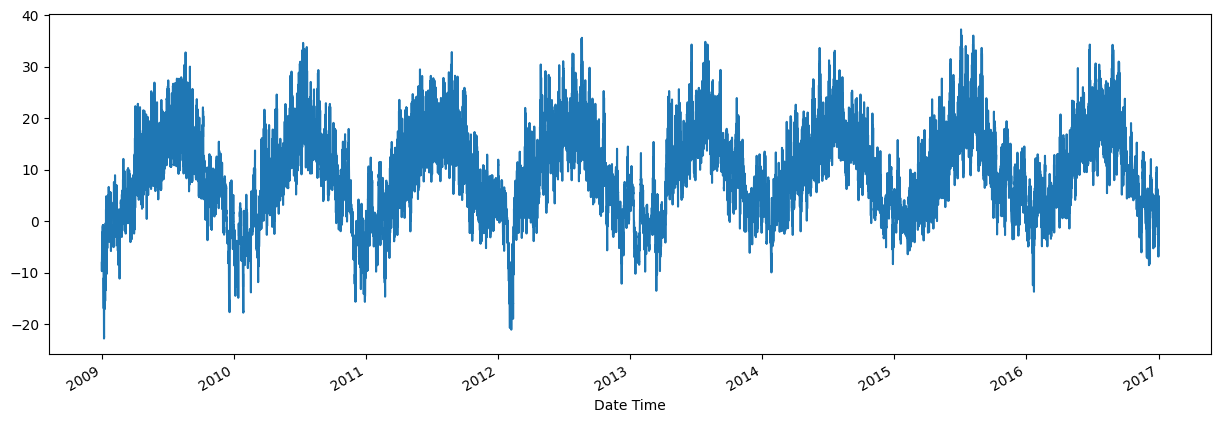

In [6]:
temp = df['T (degC)']
temp.plot(figsize = (15, 5))

In [7]:
# use 5 hours of measurement to predict 6th
# input(x) - [[[1], [2], [3], [4], [5]]] output(y) - [6]
# input(x) - [[[2], [3], [4], [5], [6]]] output(y) - [7]
# ...

# window_size - number of previous data to take
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [[a] for a in df_as_np[i:i+window_size]] # wraps output in brackets
        X.append(row)
        label = df_as_np[i+window_size] # label = actual value
        y.append(label)
    return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [9]:
X

array([[[-8.05],
        [-8.88],
        [-8.81],
        [-9.05],
        [-9.63]],

       [[-8.88],
        [-8.81],
        [-9.05],
        [-9.63],
        [-9.67]],

       [[-8.81],
        [-9.05],
        [-9.63],
        [-9.67],
        [-9.17]],

       ...,

       [[ 2.44],
        [ 1.29],
        [-0.42],
        [-0.98],
        [-1.4 ]],

       [[ 1.29],
        [-0.42],
        [-0.98],
        [-1.4 ],
        [-2.75]],

       [[-0.42],
        [-0.98],
        [-1.4 ],
        [-2.75],
        [-2.89]]])

In [10]:
y

array([-9.67, -9.17, -8.1 , ..., -2.75, -2.89, -3.93])

# Split Dataset

In [11]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

# Compile Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [13]:
model1 = Sequential()

model1.add(InputLayer((5,1)))
model1.add(LSTM(64)) #dimensionality of the output space
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
cp = ModelCheckpoint('model1/', save_best_only = True)
model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.0001), 
               metrics = [RootMeanSquaredError()])

In [15]:
model1.fit(X_train, y_train, 
           validation_data = (X_val, y_val),
           epochs = 10,
           callbacks = [cp])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 32.0849 - root_mean_squared_error: 5.6644INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 12s 5ms/step - loss: 32.0073 - root_mean_squared_error: 5.6575 - val_loss: 1.1640 - val_root_mean_squared_error: 1.0789
Epoch 2/10
1865/1875 [============================>.] - ETA: 0s - loss: 2.0747 - root_mean_squared_error: 1.4404INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 13s 7ms/step - loss: 2.0680 - root_mean_squared_error: 1.4380 - val_loss: 0.6114 - val_root_mean_squared_error: 0.7819
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.9340 - root_mean_squared_error: 0.9664INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 12s 7ms/step - loss: 0.9337 - root_mean_squared_error: 0.9663 - val_loss: 0.5461 - val_root_mean_squared_error: 0.7390
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7363 - root_mean_squared_error: 0.8581 - val_loss: 0.5513 - val_root_mean_squared_error: 0.7425
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.6849 - root_mean_squared_error: 0.8276INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 14s 7ms/step - loss: 0.6848 - root_mean_squared_error: 0.8275 - val_loss: 0.5074 - val_root_mean_squared_error: 0.7123
Epoch 6/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.6663 - root_mean_squared_error: 0.8163INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 0.6660 - root_mean_squared_error: 0.8161 - val_loss: 0.4976 - val_root_mean_squared_error: 0.7054
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6576 - root_mean_squared_error: 0.8109 - val_loss: 0.5058 - val_root_mean_squared_error: 0.7112
Epoch 8/10
1858/1875 [============================>.] - ETA: 0s - loss: 0.6521 - root_mean_squared_error: 0.8075INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6520 - root_mean_squared_error: 0.8074 - val_loss: 0.4881 - val_root_mean_squared_error: 0.6986
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6467 - root_mean_squared_error: 0.8042 - val_loss: 0.4915 - val_root_mean_squared_error: 0.7011
Epoch 10/10
1864/1875 [============================>.] - ETA: 0s - loss: 0.6426 - root_mean_squared_error: 0.8016INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.6445 - root_mean_squared_error: 0.8028 - val_loss: 0.4861 - val_root_mean_squared_error: 0.6972


In [16]:
model1 = load_model('model1/') # load best model (in val) to memory

# Compare Predictions to Real Values

In [17]:
train_predictions = model1.predict(X_train).flatten() # get rid of inner brackets
train_results = pd.DataFrame(data ={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

1875/1875 [==============================] - 3s 1ms/step


,Train Predictions,Actuals
0,-9.808926,-9.67
1,-9.614715,-9.17
2,-8.771045,-8.10
3,-7.332690,-7.66
4,-7.175337,-7.04
...,...,...
59995,6.073312,6.07
59996,7.340792,9.88
59997,12.045522,13.53
59998,15.741426,15.43


In [18]:
X_train.shape, train_predictions.shape, y_train.shape

((60000, 5, 1), (60000,), (60000,))

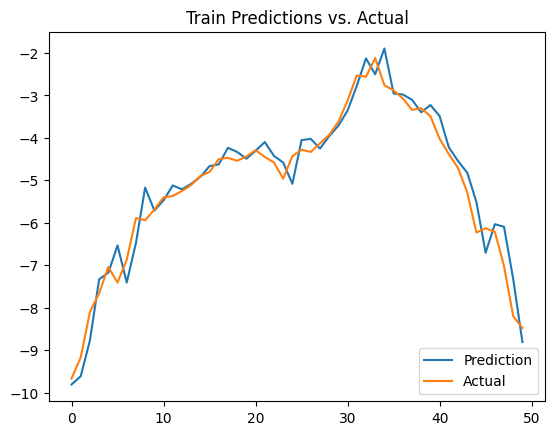

In [19]:
plt.plot(train_results['Train Predictions'][:50]) # limit range to increase focus, precision
plt.plot(train_results['Actuals'][:50]) 
plt.title('Train Predictions vs. Actual')
plt.legend(['Prediction', 'Actual'], loc= "lower right")
plt.show()

In [20]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data = {'Val Predictions': val_predictions, 'Actuals': y_val})
val_results

157/157 [==============================] - 0s 1ms/step


,Val Predictions,Actuals
0,15.296232,14.02
1,13.203540,13.67
2,13.008016,12.27
3,11.450713,11.19
4,10.364451,10.85
...,...,...
4995,17.301998,18.27
4996,17.226767,17.85
4997,17.070623,16.65
4998,15.792817,15.85


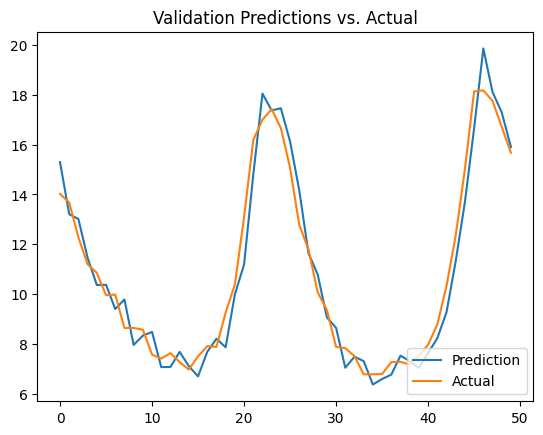

In [21]:
plt.plot(val_results['Val Predictions'][:50])
plt.plot(val_results['Actuals'][:50])
plt.title('Validation Predictions vs. Actual')
plt.legend(['Prediction', 'Actual'], loc = 'lower right')
plt.show()

In [22]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data = {'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

159/159 [==============================] - 0s 1ms/step


,Test Predictions,Actuals
0,14.339342,13.99
1,13.202180,13.46
2,12.832407,12.93
3,12.432352,12.43
4,11.986811,12.17
...,...,...
5081,-1.011955,-0.98
5082,-1.382297,-1.40
5083,-1.624473,-2.75
5084,-3.150031,-2.89


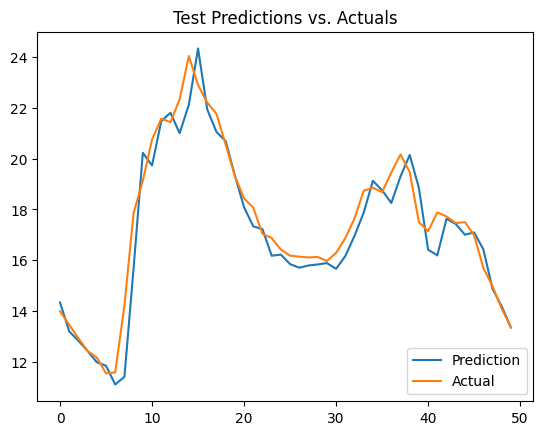

In [23]:
plt.plot(test_results['Test Predictions'][:50])
plt.plot(test_results['Actuals'][:50])
plt.title('Test Predictions vs. Actuals')
plt.legend(['Prediction', 'Actual'], loc = "lower right")
plt.show()

In [24]:
rmse1 = sqrt(mse(y_test, test_predictions))
mse1 = mse(y_test, test_predictions)
print(f'Mean Squared Error of Model 1 on Test: {mse1}')
print(f'Root Mean Squared Error of Model 1 on Test: {rmse1}')

Mean Squared Error of Model 1 on Test: 0.6621427279147934
Root Mean Squared Error of Model 1 on Test: 0.8137215297107442


Future Tasks - 
    Need to Scale Parameters
    Include multiple parameters (humidity, dew (dewpoint - temp in celsius relative to humidity), atmospheric pressure, wind) - evaluate all features for importance and remove weak ones to minimize overfitting

## Automatic Plots

In [62]:
def plot_predictions1(model, X, y, start = 0, end = 100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title('Predictions vs. Actuals')
    plt.legend(['Predictions', 'Actual'], loc = "lower right")
    plt.show()
    return df, mse(y, predictions)

159/159 [==============================] - 1s 4ms/step


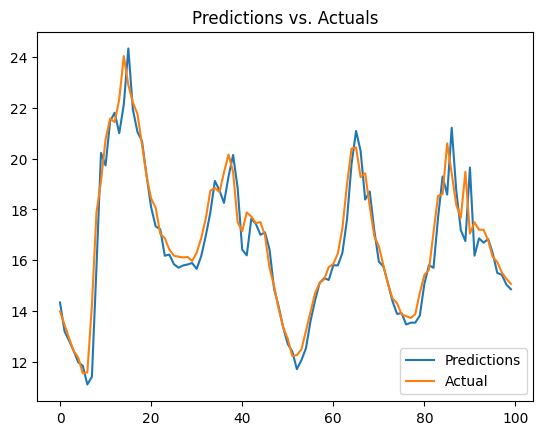

(      Predictions  Actuals
 0       14.339342    13.99
 1       13.202180    13.46
 2       12.832407    12.93
 3       12.432352    12.43
 4       11.986811    12.17
 ...           ...      ...
 5081    -1.011955    -0.98
 5082    -1.382297    -1.40
 5083    -1.624473    -2.75
 5084    -3.150031    -2.89
 5085    -3.082772    -3.93
 
 [5086 rows x 2 columns],
 0.6621427279147934)

In [63]:
plot_predictions1(model1, X_test, y_test)

# Convolutional 1D NN (CNN)

In [27]:
model2 = Sequential()
model2.add(InputLayer((5, 1))) # kernel size
model2.add(Conv1D(64, kernel_size=2)) # sliding kernel (# of windows), kernel_size=2 (take (1,2)(2,3)(3,4)(4,5). Therefore, 64x4
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Note the extremely low number of parameters

In [28]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [29]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2])

Epoch 1/10
1834/1875 [============================>.] - ETA: 0s - loss: 10.3392 - root_mean_squared_error: 3.2155INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 10.1677 - root_mean_squared_error: 3.1887 - val_loss: 1.7302 - val_root_mean_squared_error: 1.3154
Epoch 2/10
1842/1875 [============================>.] - ETA: 0s - loss: 1.5516 - root_mean_squared_error: 1.2456INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 1.5466 - root_mean_squared_error: 1.2436 - val_loss: 0.8522 - val_root_mean_squared_error: 0.9231
Epoch 3/10
1827/1875 [============================>.] - ETA: 0s - loss: 0.9256 - root_mean_squared_error: 0.9621INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.9230 - root_mean_squared_error: 0.9607 - val_loss: 0.5981 - val_root_mean_squared_error: 0.7733
Epoch 4/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.7327 - root_mean_squared_error: 0.8560INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.7322 - root_mean_squared_error: 0.8557 - val_loss: 0.5374 - val_root_mean_squared_error: 0.7331
Epoch 5/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.6901 - root_mean_squared_error: 0.8307INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6903 - root_mean_squared_error: 0.8309 - val_loss: 0.5234 - val_root_mean_squared_error: 0.7235
Epoch 6/10
1858/1875 [============================>.] - ETA: 0s - loss: 0.6740 - root_mean_squared_error: 0.8210INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6743 - root_mean_squared_error: 0.8212 - val_loss: 0.4960 - val_root_mean_squared_error: 0.7043
Epoch 7/10
1855/1875 [============================>.] - ETA: 0s - loss: 0.6646 - root_mean_squared_error: 0.8152INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6649 - root_mean_squared_error: 0.8154 - val_loss: 0.4940 - val_root_mean_squared_error: 0.7028
Epoch 8/10
1811/1875 [===========================>..] - ETA: 0s - loss: 0.6627 - root_mean_squared_error: 0.8141INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6644 - root_mean_squared_error: 0.8151 - val_loss: 0.4900 - val_root_mean_squared_error: 0.7000
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6605 - root_mean_squared_error: 0.8127 - val_loss: 0.4992 - val_root_mean_squared_error: 0.7066
Epoch 10/10
1817/1875 [============================>.] - ETA: 0s - loss: 0.6612 - root_mean_squared_error: 0.8131INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 2s 1ms/step - loss: 0.6594 - root_mean_squared_error: 0.8120 - val_loss: 0.4888 - val_root_mean_squared_error: 0.6992


# Gated Recurrent Unit (GRU)
- Less Params than LSTM, more than CNN
- More similar to LSTM
- Less Complex
- Could be less prone to overfitting

In [30]:
model3 = Sequential()
model3.add(InputLayer((5,1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
cp3 = ModelCheckpoint('model3/', save_best_only = True)
model3.compile(loss=MeanSquaredError(), 
               optimizer= Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

In [32]:
model3.fit(X_train, y_train,
               validation_data = (X_val, y_val),
               epochs = 10,
               callbacks = [cp3])

Epoch 1/10
1867/1875 [============================>.] - ETA: 0s - loss: 33.2917 - root_mean_squared_error: 5.7699INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 7s 3ms/step - loss: 33.1653 - root_mean_squared_error: 5.7589 - val_loss: 1.1301 - val_root_mean_squared_error: 1.0631
Epoch 2/10
1870/1875 [============================>.] - ETA: 0s - loss: 2.2905 - root_mean_squared_error: 1.5134INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 5s 3ms/step - loss: 2.2884 - root_mean_squared_error: 1.5127 - val_loss: 0.6473 - val_root_mean_squared_error: 0.8046
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.9732 - root_mean_squared_error: 0.9865INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.9732 - root_mean_squared_error: 0.9865 - val_loss: 0.5455 - val_root_mean_squared_error: 0.7386
Epoch 4/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.7342 - root_mean_squared_error: 0.8568INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.7334 - root_mean_squared_error: 0.8564 - val_loss: 0.5324 - val_root_mean_squared_error: 0.7297
Epoch 5/10
1858/1875 [============================>.] - ETA: 0s - loss: 0.6757 - root_mean_squared_error: 0.8220INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 5s 3ms/step - loss: 0.6748 - root_mean_squared_error: 0.8215 - val_loss: 0.4991 - val_root_mean_squared_error: 0.7065
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6568 - root_mean_squared_error: 0.8104 - val_loss: 0.5315 - val_root_mean_squared_error: 0.7291
Epoch 7/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6500 - root_mean_squared_error: 0.8062INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1875/1875 [==============================] - 6s 3ms/step - loss: 0.6504 - root_mean_squared_error: 0.8065 - val_loss: 0.4900 - val_root_mean_squared_error: 0.7000
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6452 - root_mean_squared_error: 0.8033 - val_loss: 0.4978 - val_root_mean_squared_error: 0.7056
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6431 - root_mean_squared_error: 0.8019 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6418 - root_mean_squared_error: 0.8011 - val_loss: 0.5019 - val_root_mean_squared_error: 0.7084


## Using Time as a Feature
Data has high periodicity which should be used by and accounted for in the model

In [33]:
temp_df = pd.DataFrame({'Temperature': temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [34]:
day = 60*60*24 # seconds in a day
year = 365.2425*day # seconds in a year

In [36]:
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi/ day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


By using sin and cos period signals we correlate the periodicity of events and show the model relationships between years and days.
i.e.
Jan 11 is more correlated with Jan 10 than March 4
Jan 1 is correlated with Jan 1 of the next year.

Use to group patterns and frequencies of time intervals.

In [37]:
temp_df = temp_df.drop('Seconds', axis = 1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


In [41]:
# use 5 hours of measurement to predict 6th
# input(x) - [[[t1, ds1, dc1, ys1, yc1], [t2, ds2, dc1, ys1, yc1], [t3, ds3, dc3, ys3, yc3], [t4, ds4, dc4, ys4, yc4], [t5, ds5, dc4, ys4, yc4]]] output(y) - [t6]
# input(x) - [[[t2, ds2, ...], [t3, ds3, ...], [t4, ds4, ...], [t5, ds5, ...], [t6, ds6, ...]]] output(y) - [t7]
# input(x) - [[[t3, ds3, ...], [t4, ds4, ...], [t5, ds5, ...], [t6, ds6, ...], [t7, ds7, ...]]] output(y) - [t8]
# ...

def df_to_X_y2(df, window_size = 6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]] # creates a list of lists - a list of rows
        X.append(row)
        label = df_as_np[i+window_size][0] # label = actual value
        y.append(label)
    return np.array(X), np.array(y)

In [44]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape # Created tensors

((70085, 6, 5), (70085,))

TODO: Test different windowsizes for increased accuracy

## Spliting into Training and Validation Sets

In [43]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

## Pre-processing Data
### Standardization
Temperature is on a significantly different scale than the period signals


In [46]:
temp_training_mean = np.mean(X2_train[:, :, 0]) # all examples (60000), all timestamps (6), only temperature [0]
temp_training_std = np.std(X2_train[:, :, 0])
def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X

In [47]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.04009706e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
  

## LSTM w/ Processed Data

In [49]:
model4 = Sequential()
model4.add(InputLayer((6, 5))) # 6 Time steps, 5 variables of interest
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()           

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate=0.0001), 
               metrics = [RootMeanSquaredError()])

In [54]:
model4.fit(X2_train, y2_train,
           validation_data = (X2_val, y2_val),
           epochs = 10,
           callbacks = [cp4])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.5175 - root_mean_squared_error: 0.7194INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5176 - root_mean_squared_error: 0.7195 - val_loss: 0.4076 - val_root_mean_squared_error: 0.6384
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.5169 - root_mean_squared_error: 0.7190 - val_loss: 0.4084 - val_root_mean_squared_error: 0.6391
Epoch 3/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.5154 - root_mean_squared_error: 0.7179INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 16s 9ms/step - loss: 0.5153 - root_mean_squared_error: 0.7179 - val_loss: 0.4033 - val_root_mean_squared_error: 0.6351
Epoch 4/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.5145 - root_mean_squared_error: 0.7173INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 16s 9ms/step - loss: 0.5148 - root_mean_squared_error: 0.7175 - val_loss: 0.4012 - val_root_mean_squared_error: 0.6334
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5133 - root_mean_squared_error: 0.7165 - val_loss: 0.4107 - val_root_mean_squared_error: 0.6409
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5113 - root_mean_squared_error: 0.7150 - val_loss: 0.4052 - val_root_mean_squared_error: 0.6366
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.5104 - root_mean_squared_error: 0.7144INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5103 - root_mean_squared_error: 0.7144 - val_loss: 0.4001 - val_root_mean_squared_error: 0.6325
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5096 - root_mean_squared_error: 0.7138 - val_loss: 0.4002 - val_root_mean_squared_error: 0.6326
Epoch 9/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.5075 - root_mean_squared_error: 0.7124INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 15s 8ms/step - loss: 0.5077 - root_mean_squared_error: 0.7125 - val_loss: 0.3989 - val_root_mean_squared_error: 0.6316
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.5071 - root_mean_squared_error: 0.7121 - val_loss: 0.4044 - val_root_mean_squared_error: 0.6359


159/159 [==============================] - 1s 4ms/step


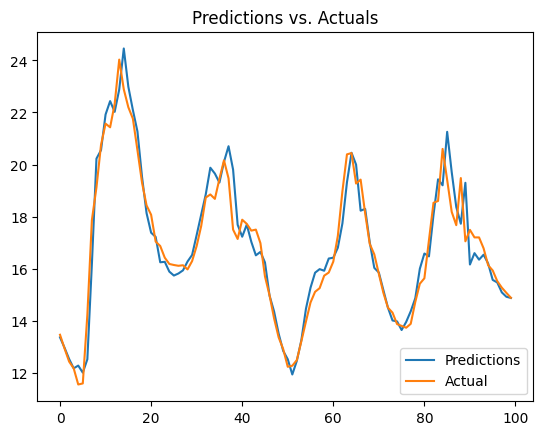

(      Predictions  Actuals
 0       13.358045    13.46
 1       12.959788    12.93
 2       12.529362    12.43
 3       12.170332    12.17
 4       12.275500    11.55
 ...           ...      ...
 5080    -1.077682    -0.98
 5081    -1.519335    -1.40
 5082    -1.879474    -2.75
 5083    -3.302721    -2.89
 5084    -3.302891    -3.93
 
 [5085 rows x 2 columns],
 0.46397138608282973)

In [64]:
plot_predictions1(model4, X2_test, y2_test)

## Predicting Temperature and Pressure

In [110]:
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis = 1)
p_temp_df.head()

,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


In [111]:
def df_to_X_y3(df, window_size=7):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
        y.append(label)
    return np.array(X), np.array(y)

In [112]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape
X3, y3


(array([[[ 9.96500000e+02, -8.05000000e+00,  2.58819045e-01,
           9.65925826e-01,  1.00491198e-02,  9.99949506e-01],
         [ 9.96620000e+02, -8.88000000e+00,  5.00000000e-01,
           8.66025404e-01,  1.07658633e-02,  9.99942046e-01],
         [ 9.96840000e+02, -8.81000000e+00,  7.07106781e-01,
           7.07106781e-01,  1.14826014e-02,  9.99934073e-01],
         ...,
         [ 9.97460000e+02, -9.63000000e+00,  9.65925826e-01,
           2.58819045e-01,  1.29160593e-02,  9.99916584e-01],
         [ 9.97710000e+02, -9.67000000e+00,  1.00000000e+00,
           4.33995489e-12,  1.36327785e-02,  9.99907069e-01],
         [ 9.98330000e+02, -9.17000000e+00,  9.65925826e-01,
          -2.58819045e-01,  1.43494907e-02,  9.99897041e-01]],
 
        [[ 9.96620000e+02, -8.88000000e+00,  5.00000000e-01,
           8.66025404e-01,  1.07658633e-02,  9.99942046e-01],
         [ 9.96840000e+02, -8.81000000e+00,  7.07106781e-01,
           7.07106781e-01,  1.14826014e-02,  9.99934073e-01],

In [113]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

In [114]:
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):
    X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
    X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3
    return X

def preprocess_output3(y):
    y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
    y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
    return y

In [115]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

array([[[-1.07355644e+00,  1.04009390e+00, -9.65925826e-01,
          2.58819045e-01,  5.22877889e-01, -8.52407598e-01],
        [-1.00807435e+00,  9.90728707e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51080673e-01,  8.49685305e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        ...,
        [-8.80748054e-01,  6.66328883e-01, -2.58819045e-01,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01],
        [-8.29817537e-01,  5.37039098e-01, -7.16474371e-12,
          1.00000000e+00,  5.19819584e-01, -8.54276068e-01],
        [-8.01927015e-01,  4.74744929e-01,  2.58819045e-01,
          9.65925826e-01,  5.19207120e-01, -8.54648446e-01]],

       [[-1.00807435e+00,  9.90728707e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51080673e-01,  8.49685305e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        [-9.14701

In [93]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[-0.7934386 ,  0.41245076],
       [-0.76312281,  0.35368268],
       [-0.72189335,  0.32312327],
       ...,
       [ 1.48145784, -1.43051636],
       [ 1.41597574, -1.44697142],
       [ 1.35049365, -1.56920903]])

In [94]:
model5 = Sequential()
model5.add(InputLayer((7, 6)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear'))

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
Total params: 18714 (73.10 KB)
Trainable params: 18714 (73.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

In [98]:
model5.fit(X3_train, y3_train,
           validation_data = (X3_val, y3_val),
           epochs = 10,
           callbacks = [cp5])

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1221 - root_mean_squared_error: 0.3494INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 31s 15ms/step - loss: 0.1221 - root_mean_squared_error: 0.3494 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1779
Epoch 2/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1510INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 3/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1069INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 24s 13ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0882INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 5/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0809INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 6/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0764INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0736INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 8/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0719INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 14ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 9/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 10/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0703INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


1875/1875 [==============================] - 25s 13ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607


In [101]:
def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
    p_actuals, temp_actuals = y[:, 0], y[:, 1]
    df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                           'Temperature Actuals': temp_actuals,
                           'Pressure Predictions': p_preds,
                           'Pressure Actuals': p_actuals
                           })
    plt.plot(df['Temperature Predictions'][start:end])
    plt.plot(df['Temperature Actuals'][start:end])
    plt.plot(df['Pressure Predictions'][start:end])
    plt.plot(df['Pressure Actuals'][start:end])
    return df[start:end]

2191/2191 [==============================] - 12s 5ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,-2.170198,-2.059335,1.195274,1.236506
1,-2.004961,-2.007619,1.297123,1.299563
2,-1.942109,-1.934747,1.358951,1.369896
3,-1.867705,-1.978235,1.417508,1.442654
4,-1.951201,-1.914765,1.483278,1.373534
...,...,...,...,...
95,-1.335256,-1.351767,-0.323817,-0.264731
96,-1.379669,-1.426990,-0.205179,-0.158020
97,-1.457446,-1.472829,-0.075993,-0.067072
98,-1.481037,-1.493986,0.017324,0.031151


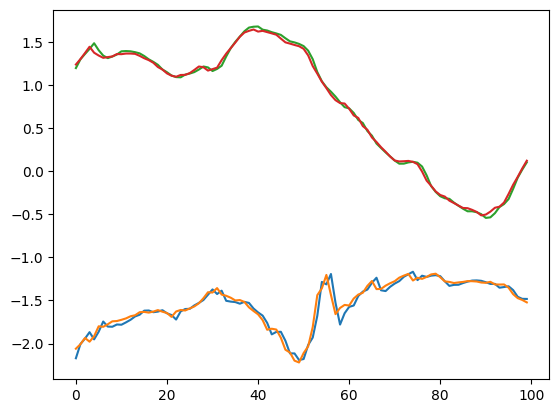

In [102]:
plot_predictions2(model5, X3, y3)

In [103]:
def postprocess(arr, std, mean):
    arr = (arr*std) + mean
    return arr
    

In [107]:
def plot_predictions3(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    p_preds, temp_preds = postprocess(predictions[:, 0],
                                      temp_training_std3,
                                      temp_training_mean3), postprocess(predictions[:, 1],
                                      p_training_std3,
                                      p_training_mean3)
    p_actuals, temp_actuals = y[:, 0], y[:, 1]
    df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                           'Temperature Actuals': temp_actuals,
                           'Pressure Predictions': p_preds,
                           'Pressure Actuals': p_actuals
                           })
    plt.plot(df['Temperature Predictions'][start:end])
    plt.plot(df['Temperature Actuals'][start:end])
    plt.plot(df['Pressure Predictions'][start:end])
    plt.plot(df['Pressure Actuals'][start:end])
    return df[start:end]

159/159 [==============================] - 1s 6ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.799805,0.412451,982.488953,-0.793439
1,12.429200,0.353683,982.579712,-0.763123
2,12.125241,0.323123,982.855408,-0.721893
3,12.181135,0.250251,983.273682,-0.652773
4,11.805317,0.254952,983.927490,-0.652773
...,...,...,...,...
95,15.210037,0.716869,985.611450,-0.416310
96,14.914813,0.687485,985.582703,-0.399333
97,14.816938,0.663978,985.723694,-0.399333
98,14.884857,0.641646,985.816895,-0.400546


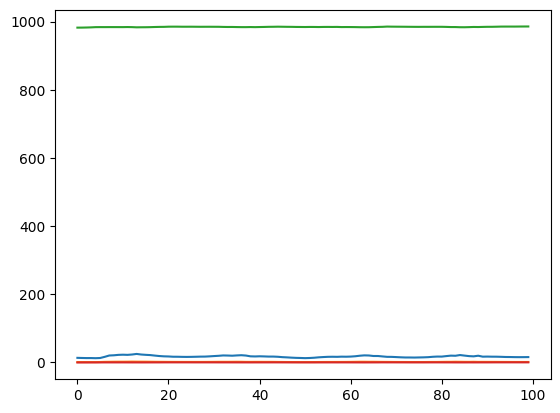

In [108]:
post_processed_df = plot_predictions3(model5, X3_test, y3_test)
post_processed_df

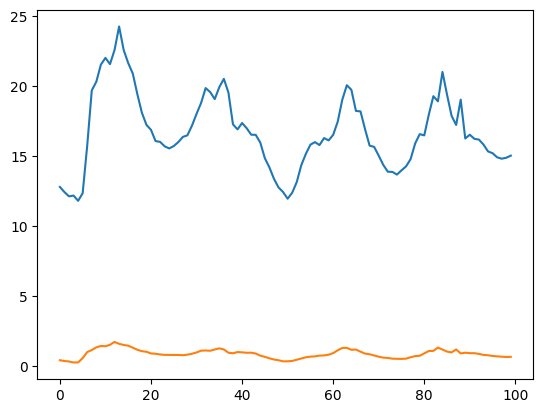

In [109]:
start, end = 0, 100
plt.plot(post_processed_df['Temperature Predictions'][start:end])
plt.plot(post_processed_df['Temperature Actuals'][start:end])    

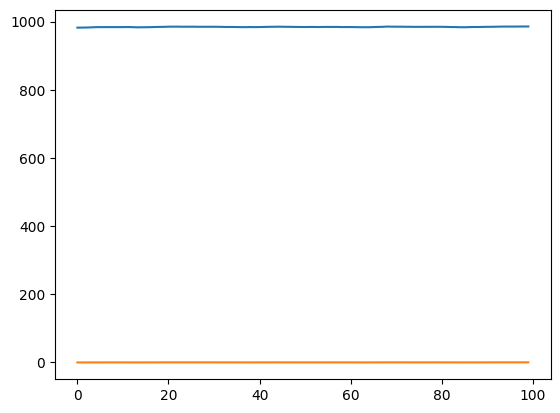

In [116]:
plt.plot(post_processed_df['Pressure Predictions'][start:end])
plt.plot(post_processed_df['Pressure Actuals'][start:end])   

In [118]:
model6 = Sequential()
model6.add(InputLayer((7,6)))
model6.add(LSTM(32, return_sequences=True)) #passes processed LSTM into next one
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 7, 32)             4992      
                                                                 
 lstm_6 (LSTM)               (None, 64)                24832     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                                 
Total params: 30362 (118.60 KB)
Trainable params: 30362 (118.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
